<a href="https://colab.research.google.com/github/PAlena/SQL/blob/main/pavlova_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [224]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt 
import statistics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
#!pip install catboost
from catboost import Pool
from catboost import CatBoostClassifier
from catboost import Pool
from sklearn.metrics import confusion_matrix, recall_score, mean_squared_error, accuracy_score, roc_auc_score, f1_score, log_loss
from catboost.utils import select_threshold
import matplotlib.pyplot as plt
from catboost.utils import get_roc_curve
from catboost.utils import get_fpr_curve
from catboost.utils import get_fnr_curve

# Data preparation

In [783]:
testbattles = pd.read_csv('testbattles.csv')
testplayers = pd.read_csv('testplayers.csv')
trainbattles = pd.read_csv('trainbattles.csv')
trainplayers = pd.read_csv('trainplayers.csv')

train = trainbattles.merge(trainplayers, on="player_id")
test = testbattles.merge(testplayers, on="player_id")

In [3]:
print("Missing values at train data set:{}".format(train.isnull().sum().sum()))
print("Missing values at test data set:{}".format(test.isnull().sum().sum()))


Missing values at train data set:0
Missing values at test data set:0


In [23]:
train.describe().applymap(lambda x: f"{x:0.2f}")

,player_id,battle_seq_num,damage_dealt,damage_received,kills_made,xp,shots,successful_shots,mileage,is_winner,survived,battle_level,is_tier_ten
count,800000.00,800000.00,800000.00,800000.00,800000.00,800000.00,800000.00,800000.00,800000.00,800000.00,800000.00,800000.00,800000.00
mean,5177.43,50.35,229.34,327.23,0.58,418.28,5.50,3.28,897.30,0.45,0.23,4.13,0.46
std,2996.88,28.86,360.58,305.62,1.05,576.23,11.29,6.78,596.93,0.50,0.42,1.86,0.50
min,2.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
25%,2572.75,25.00,0.00,140.00,0.00,99.00,1.00,0.00,486.00,0.00,0.00,3.00,0.00
50%,5174.50,50.00,110.00,250.00,0.00,232.00,3.00,1.00,765.00,0.00,0.00,4.00,0.00
75%,7779.25,75.00,288.00,405.00,1.00,498.00,6.00,4.00,1173.00,1.00,0.00,5.00,1.00
max,10363.00,100.00,9851.00,3240.00,13.00,25902.00,607.00,230.00,14576.00,1.00,1.00,10.00,1.00


In [5]:
test.describe().applymap(lambda x: f"{x:0.2f}")

,player_id,battle_seq_num,damage_dealt,damage_received,kills_made,xp,shots,successful_shots,mileage,is_winner,survived,battle_level
count,200000.00,200000.00,200000.00,200000.00,200000.00,200000.00,200000.00,200000.00,200000.00,200000.00,200000.00,200000.00
mean,5213.06,50.35,232.94,323.70,0.59,429.09,5.61,3.34,901.07,0.45,0.24,4.11
std,2960.11,28.86,370.06,298.76,1.06,599.99,11.62,6.76,601.52,0.50,0.42,1.82
min,7.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
25%,2688.75,25.00,0.00,140.00,0.00,101.00,1.00,0.00,487.00,0.00,0.00,3.00
50%,5234.50,50.00,112.00,250.00,0.00,234.00,3.00,1.00,768.00,0.00,0.00,4.00
75%,7754.75,75.00,294.00,405.00,1.00,504.00,6.00,4.00,1179.00,1.00,0.00,5.00
max,10365.00,100.00,9551.00,3000.00,10.00,13814.00,447.00,190.00,10480.00,1.00,1.00,10.00


Text(0.5, 0, 'battle_seq_num')

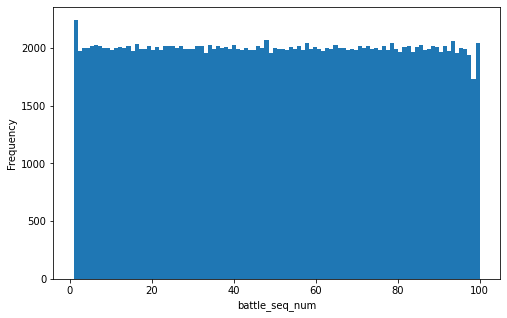

In [784]:
plt.plot()
test['battle_seq_num'].plot(kind='hist', bins=100, figsize=(8, 5))
plt.xlabel('battle_seq_num')

In [24]:
list_id = test['player_id'].unique().tolist()
test = test.sort_values(by=['player_id', 'date', 'battle_seq_num'])
list_id.sort()
for id in range(len(list_id)):
    for i in range(1,101):
      if test.battle_seq_num[i-1+100*id] != i:
        test.battle_seq_num[i-1+100*id] = i

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [25]:
list_id = train['player_id'].unique().tolist()
train = train.sort_values(by=['player_id', 'date', 'battle_seq_num'])
list_id.sort() 
for id in range(len(list_id)):
    for i in range(1,101):
      if train.battle_seq_num[i-1+100*id] != i:
        train.battle_seq_num[i-1+100*id] = i

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [12]:
print('Train data set. Mean value for battle_seq_num: ' + str(statistics.mean(train.battle_seq_num)))
print('Test data set. mean value for battle_seq_num: ' + str(statistics.mean(test.battle_seq_num)))

Train data set. Mean value for battle_seq_num: 50.5
Test data set. mean value for battle_seq_num: 50.5


In [78]:
train.to_csv('train.csv')
test.to_csv('test.csv')

# Aggregate features

In [723]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [724]:
# train data
# get mean
train_for_agr = train
train_agr = train_for_agr.groupby(by=["player_id"]).mean()

list_id = train['player_id'].unique().tolist()
train_agr['frequency'] = 0

# get frequency
label = train[['is_tier_ten','player_id']]
label = label.groupby(by=["player_id"]).max()
for i in list_id:
  train2 = train[train['player_id'] == i]
  train2 = train2[['date','battle_seq_num']]
  train2_sum = train2.groupby(by=["date"]).count()
  train_agr['frequency'][i] = len(train2_sum)

# get sum
train_for_agr2 = train[['player_id','battle_level','is_winner', 'survived']]
train_agr2 = train_for_agr2.groupby(by=["player_id"]).sum()

# merge the data
train = train_agr.merge(label, on = "player_id")
train.reset_index()

train = train_agr2.merge(train, on = "player_id")
train = train.reset_index()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [725]:
# test data
# get mean
test_for_agr = test
test_agr = test_for_agr.groupby(by=["player_id"]).mean()

list_id = test['player_id'].unique().tolist()
test_agr['frequency'] = 0

# get frequency
label = test[['player_id']]
label = label.groupby(by=["player_id"]).max()
for i in list_id:
  test2 = test[test['player_id'] == i]
  test2 = test2[['date','battle_seq_num']]
  test2_sum = test2.groupby(by=["date"]).count()
  test_agr['frequency'][i] = len(test2_sum)

# get sum
test_for_agr2 = test[['player_id','battle_level','is_winner', 'survived']]
test_agr2 = test_for_agr2.groupby(by=["player_id"]).sum()

# merge the data
test = test_agr.merge(label, on = "player_id")
test.reset_index()

test = test_agr2.merge(test, on = "player_id")
test = test.reset_index()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [726]:
train.to_csv('train_mean_max.csv')
test.to_csv('test_mean_max.csv')

# Features

In [754]:
train = pd.read_csv('train_mean_max.csv')
test_main = pd.read_csv('test_mean_max.csv')
test_main = test_main.drop('Unnamed: 0',axis = 1)

In [755]:
train['damage_received_per_day'] = train['damage_received']/train['frequency']
train['kills_made_per_day'] = train['kills_made']/train['frequency']
train['xp_per_day'] = train['xp']/train['frequency']
train['shots_per_day'] = train['shots']/train['frequency']
train['is_winner_x_per_day'] = train['is_winner_x']/train['frequency']
train['survived_x_per_day'] = train['survived_x']/train['frequency']
train['battle_level_x_per_day'] = train['battle_level_x']/train['frequency'] 

test_main['damage_received_per_day'] = test_main['damage_received']/test_main['frequency']
test_main['kills_made_per_day'] = test_main['kills_made']/test_main['frequency']
test_main['xp_per_day'] = test_main['xp']/test_main['frequency']
test_main['shots_per_day'] = test_main['shots']/test_main['frequency']
test_main['is_winner_x_per_day'] = test_main['is_winner_x']/test_main['frequency']
test_main['survived_x_per_day'] = test_main['survived_x']/test_main['frequency']
test_main['battle_level_x_per_day'] = test_main['battle_level_x']/test_main['frequency']

test_main = test_main.sort_index(axis = 1)

In [756]:
list_to_drop = ['successful_shots', 'frequency', 'survived_x', 'battle_level_x','Unnamed: 0', 'battle_seq_num', 'is_tier_ten_y', 'is_winner_x']
for col in list_to_drop:
  train = train.drop(col, axis=1)

In [757]:
train, test = train_test_split(train, train_size=0.75)
y = train.is_tier_ten_x
X = train.drop('player_id', axis=1)
X = X.drop('is_tier_ten_x', axis=1)
X = X.sort_index(axis = 1)

y_test = test.is_tier_ten_x
X_test = test.drop('is_tier_ten_x', axis=1)
X_test = X_test.drop('player_id', axis=1)
X_test = X_test.sort_index(axis = 1)

In [758]:
X.dtypes

categorical_features_indices = np.where(X.dtypes != float)[0]
categorical_features_indices 

pool = Pool(data=X, label=y, cat_features = categorical_features_indices)

data = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_validation, y_train, y_validation = data

train_pool = Pool(
    data=X_train, 
    label=y_train,   cat_features = categorical_features_indices)

validation_pool = Pool(
    data=X_validation, 
    label=y_validation,     cat_features = categorical_features_indices)

model = CatBoostClassifier(
    iterations = 100,
     verbose = 100, 
    cat_features = categorical_features_indices
)
model.fit(train_pool, eval_set=validation_pool);

Learning rate set to 0.127109
0:	learn: 0.6828553	test: 0.6842461	best: 0.6842461 (0)	total: 5.14ms	remaining: 509ms
99:	learn: 0.5598384	test: 0.6352634	best: 0.6335133 (76)	total: 444ms	remaining: 0us

bestTest = 0.6335133424
bestIteration = 76

Shrink model to first 77 iterations.


In [759]:
eval_pool = Pool(X_validation, y_validation, cat_features = categorical_features_indices)
(fpr, tpr, thresholds) = get_roc_curve(model, eval_pool)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f'Optimal threshold: {optimal_threshold}')

Optimal threshold: 0.4448942072201998


In [760]:
probability_class_1 = model.predict_proba(X_test)[:, 1]
list2 = probability_class_1.tolist()
for i in range(len(list2)):
  if list2[i] > optimal_threshold:
    list2[i] = 1
  else:
    list2[i] = 0   
    
acc_score = accuracy_score(list2, y_test)
print(f'Accuracy:' + str(acc_score))

Accuracy:0.6315


In [761]:
np.array(model.get_feature_importance(prettified=True))

array([['damage_received', 16.299526015079245],
       ['battle_level_y', 13.123554780352842],
       ['shots', 6.446892860608268],
       ['Unnamed: 0.1', 5.896422109487564],
       ['battle_level_x_per_day', 5.637059268445425],
       ['is_winner_x_per_day', 5.446045112135893],
       ['damage_received_per_day', 5.391081295617651],
       ['mileage', 5.308535277291752],
       ['shots_per_day', 5.24287324164155],
       ['xp', 5.029518370044711],
       ['damage_dealt', 4.598109095616193],
       ['survived_x_per_day', 4.368779888057639],
       ['kills_made', 4.318694220056079],
       ['kills_made_per_day', 3.40002149576088],
       ['survived_y', 3.2701072765847927],
       ['xp_per_day', 3.182485723257583],
       ['is_winner_y', 3.040293969961959]], dtype=object)

In [762]:
np.array(model.get_feature_importance(
    data=train_pool, 
    type='LossFunctionChange', 
    prettified=True
))

array([['damage_received', 0.013562337638232225],
       ['battle_level_y', 0.008289270284579597],
       ['damage_received_per_day', 0.0056003734512142245],
       ['Unnamed: 0.1', 0.004698287620114705],
       ['xp', 0.004387439954151695],
       ['shots', 0.0038843004091575484],
       ['is_winner_x_per_day', 0.003451203145029891],
       ['battle_level_x_per_day', 0.0033266735501672473],
       ['mileage', 0.003307730770473638],
       ['shots_per_day', 0.003143933065510751],
       ['survived_x_per_day', 0.0028902339340713956],
       ['damage_dealt', 0.002821033158807218],
       ['kills_made', 0.0028010314109689904],
       ['kills_made_per_day', 0.0026048087939206654],
       ['survived_y', 0.0023161991959730344],
       ['xp_per_day', 0.002252259322504946],
       ['is_winner_y', 0.0019095890039502184]], dtype=object)

In [ ]:
# prediction
probability_class_1 = model.predict_proba(test_main)[:, 1]
list3 = probability_class_1.tolist()
for i in range(len(list3)):
  if list3[i] > optimal_threshold:
    list3[i] = 1
  else:
    list3[i] = 0   

In [779]:
list3[:5]

[1, 1, 0, 0, 0]

In [782]:
prediction = test_main[['player_id']]
prediction['prediction'] = 0
prediction['prediction'] = list3
prediction.to_csv('prediction.csv')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
